# Preprocessing

## Initial setup

### Packages

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Dataset reading

In [103]:
original_df = pd.read_csv('../data/dataset.csv')
print(f"Dataset loaded: {original_df.shape[0]} rows × {original_df.shape[1]} columns")
print(original_df.columns)

Dataset loaded: 21742 rows × 58 columns
Index(['Unnamed: 0', 'id', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful',
       'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude',
       'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name',
       'street_number', 'portal', 'floor', 'is_floor_under', 'door',
       'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'are_pets_allowed', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_furnished', 'is_kitchen_equipped', 'is_accessible',
       'has_green_zones', 'energy_certificate', 'has_parking',
       'has_private_parking', 'has_public_parking',
     

We just keep the columns we will be processing

In [104]:
columns = ['street_name',
           'floor',
           'house_type_id',
           'sq_mt_built', 'sq_mt_useful', 'n_rooms', 'has_lift',
        ]
AMMENITIES_COLUMNS = ['has_ac', 'has_pool']
HEATING_COLUMNS = ['has_central_heating', 'has_individual_heating']
PARKING_COLUMNS = ['has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price']
ORIENTATION_COLUMNS = ['is_orientation_north', 'is_orientation_east', 'is_orientation_south', 'is_orientation_west']
RESPONSE_COLUMN = ['buy_price']

columns += AMMENITIES_COLUMNS
columns += HEATING_COLUMNS
columns += PARKING_COLUMNS
columns += ORIENTATION_COLUMNS
columns += RESPONSE_COLUMN

df = original_df[columns]

### NaN analysis

We display the information of NaN (null) for by columns

In [105]:
nulls = df.isnull().mean() * 100
print("NaN percentage by column:")
display(nulls.sort_values(ascending=False))

NaN percentage by column:


has_private_parking             100.000000
has_public_parking              100.000000
has_pool                         76.216539
is_parking_included_in_price     64.497286
sq_mt_useful                     62.156195
has_ac                           48.436206
is_orientation_west              47.760096
is_orientation_south             47.760096
is_orientation_east              47.760096
is_orientation_north             47.760096
has_individual_heating           37.411462
has_central_heating              37.411462
street_name                      27.159415
floor                            11.990617
has_lift                         10.974151
house_type_id                     1.798363
sq_mt_built                       0.579524
has_parking                       0.000000
n_rooms                           0.000000
buy_price                         0.000000
dtype: float64

### Distinct values analysis

Distinct values in street_name:
street_name
NaN                                     5905
Paseo de la Castellana                   116
Calle de Bravo Murillo                    69
Calle del Príncipe de Vergara             60
Calle de Embajadores                      58
                                        ... 
Calle Peonias                              1
Calle de Hermenegildo Bielsa               1
Avenida de los arces                       1
Calle del Estrecho de Mesina, Madrid       1
Calle Burriana                             1
Name: count, Length: 6163, dtype: int64
---------
Distinct values in floor:
floor
1                       4440
2                       3546
3                       3001
NaN                     2607
4                       2323
Bajo                    2144
5                       1310
6                        913
7                        556
8                        326
Entreplanta exterior     236
9                        181
Semi-sótano exterior      55
Se

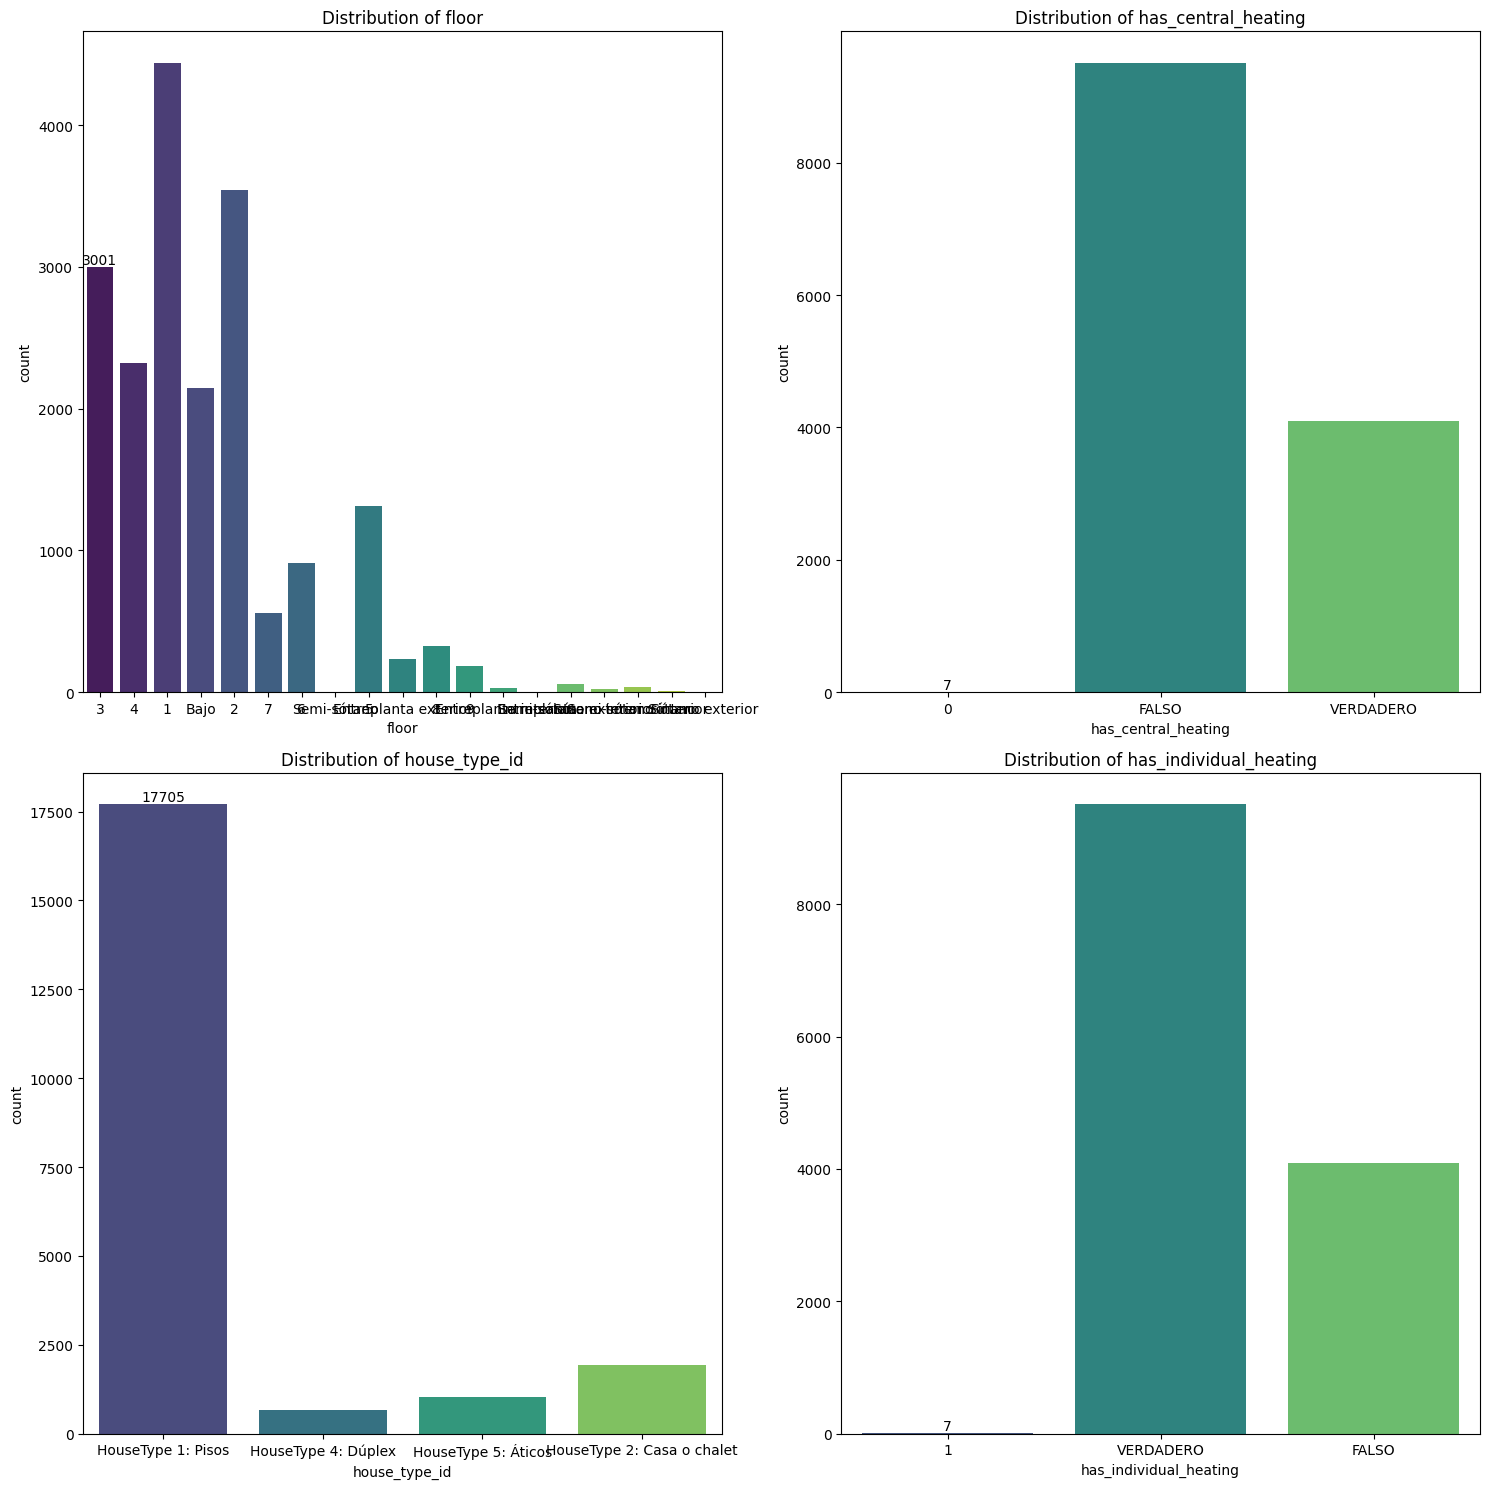

In [106]:
print("Distinct values in street_name:")
print(df['street_name'].value_counts(dropna=False))
print('---------')

print("Distinct values in floor:")
print(df['floor'].value_counts(dropna=False))
print('---------')

print("Distinct values in house_type_id:")
print(df['house_type_id'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_central_heating:")
print(df['has_central_heating'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_individual_heating:")
print(df['has_individual_heating'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))


sns.countplot(x='floor', data=df, ax=axes[0][0], palette='viridis')
axes[0][0].set_title('Distribution of floor')
axes[0][0].set_xlabel('floor')
axes[0][0].bar_label(axes[0][0].containers[0])

sns.countplot(x='house_type_id', data=df, ax=axes[1][0], palette='viridis')
axes[1][0].set_title('Distribution of house_type_id')
axes[1][0].set_xlabel('house_type_id')
axes[1][0].bar_label(axes[1][0].containers[0])

sns.countplot(x='has_central_heating', data=df, ax=axes[0][1], palette='viridis')
axes[0][1].set_title('Distribution of has_central_heating')
axes[0][1].set_xlabel('has_central_heating')
axes[0][1].bar_label(axes[0][1].containers[0])

sns.countplot(x='has_individual_heating', data=df, ax=axes[1][1], palette='viridis')
axes[1][1].set_title('Distribution of has_individual_heating')
axes[1][1].set_xlabel('has_individual_heating')
axes[1][1].bar_label(axes[1][1].containers[0])

plt.tight_layout()
plt.show()

Distinct values in sq_mt_built:
sq_mt_built
70.0     494
60.0     484
80.0     427
65.0     377
90.0     357
        ... 
803.0      1
486.0      1
634.0      1
502.0      1
427.0      1
Name: count, Length: 679, dtype: int64
---------
Distinct values in sq_mt_useful:
sq_mt_useful
NaN      13514
70.0       277
60.0       232
80.0       219
50.0       203
         ...  
778.0        1
16.0         1
531.0        1
354.0        1
351.0        1
Name: count, Length: 409, dtype: int64
---------
Distinct values in n_rooms:
n_rooms
3     7214
2     5499
4     3367
1     2267
5     1757
6      715
0      439
7      259
8      112
9       54
10      26
11      10
12       9
13       6
24       3
15       2
16       1
18       1
14       1
Name: count, dtype: int64
---------
Distinct values in has_lift:
has_lift
VERDADERO    14885
FALSO         4448
NaN           2386
0               13
1               10
Name: count, dtype: int64
---------


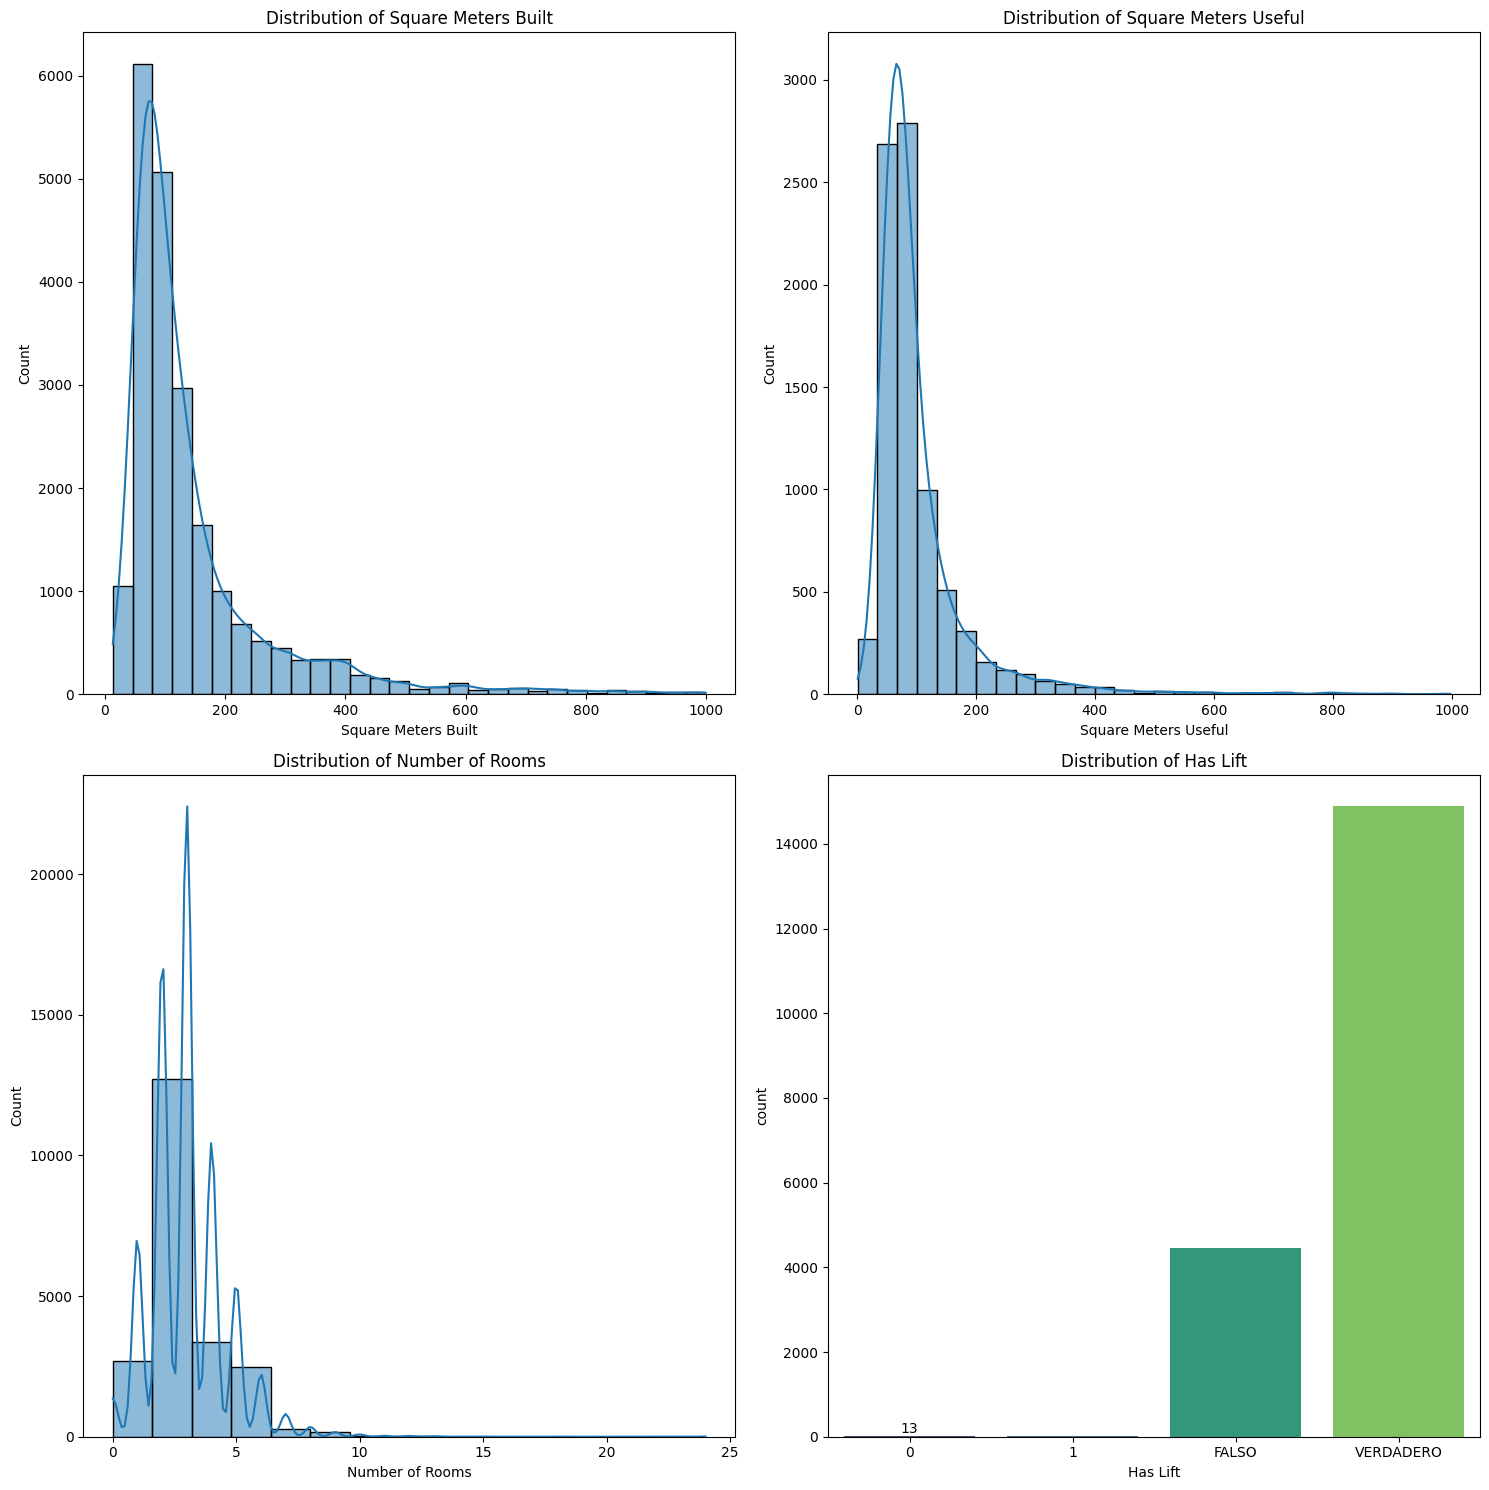

In [107]:
print("Distinct values in sq_mt_built:")
print(df['sq_mt_built'].value_counts(dropna=False))
print('---------')

print("Distinct values in sq_mt_useful:")
print(df['sq_mt_useful'].value_counts(dropna=False))
print('---------')

print("Distinct values in n_rooms:")
print(df['n_rooms'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_lift:")
print(df['has_lift'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Histogram for sq_mt_built
sns.histplot(data=df, x='sq_mt_built', bins=30, ax=axes[0][0], kde=True)
axes[0][0].set_title('Distribution of Square Meters Built')
axes[0][0].set_xlabel('Square Meters Built')

# Histogram for sq_mt_useful
sns.histplot(data=df, x='sq_mt_useful', bins=30, ax=axes[0][1], kde=True)
axes[0][1].set_title('Distribution of Square Meters Useful')
axes[0][1].set_xlabel('Square Meters Useful')

# Histogram for n_rooms
sns.histplot(data=df, x='n_rooms', bins=15, ax=axes[1][0], kde=True)
axes[1][0].set_title('Distribution of Number of Rooms')
axes[1][0].set_xlabel('Number of Rooms')

# Countplot for has_lift
sns.countplot(x='has_lift', data=df, ax=axes[1][1], palette='viridis')
axes[1][1].set_title('Distribution of Has Lift')
axes[1][1].set_xlabel('Has Lift')
axes[1][1].bar_label(axes[1][1].containers[0])

plt.tight_layout()
plt.show()

Distinct values in has_parking:
has_parking
FALSO        14003
VERDADERO     7714
0               20
1                5
Name: count, dtype: int64
---------
Distinct values in has_private_parking:
has_private_parking
NaN    21742
Name: count, dtype: int64
---------
Distinct values in has_public_parking:
has_public_parking
NaN    21742
Name: count, dtype: int64
---------
Distinct values in is_parking_included_in_price:
is_parking_included_in_price
NaN          14023
VERDADERO     7110
FALSO          604
1                5
Name: count, dtype: int64
---------
Distinct values in has_ac:
has_ac
VERDADERO    11200
NaN          10531
1               11
Name: count, dtype: int64
---------
Distinct values in has_pool:
has_pool
NaN          16571
VERDADERO     5167
1                4
Name: count, dtype: int64
---------
Distinct values in is_orientation_north:
is_orientation_north
NaN          10384
FALSO         8559
VERDADERO     2790
0                8
1                1
Name: count, dtype: int

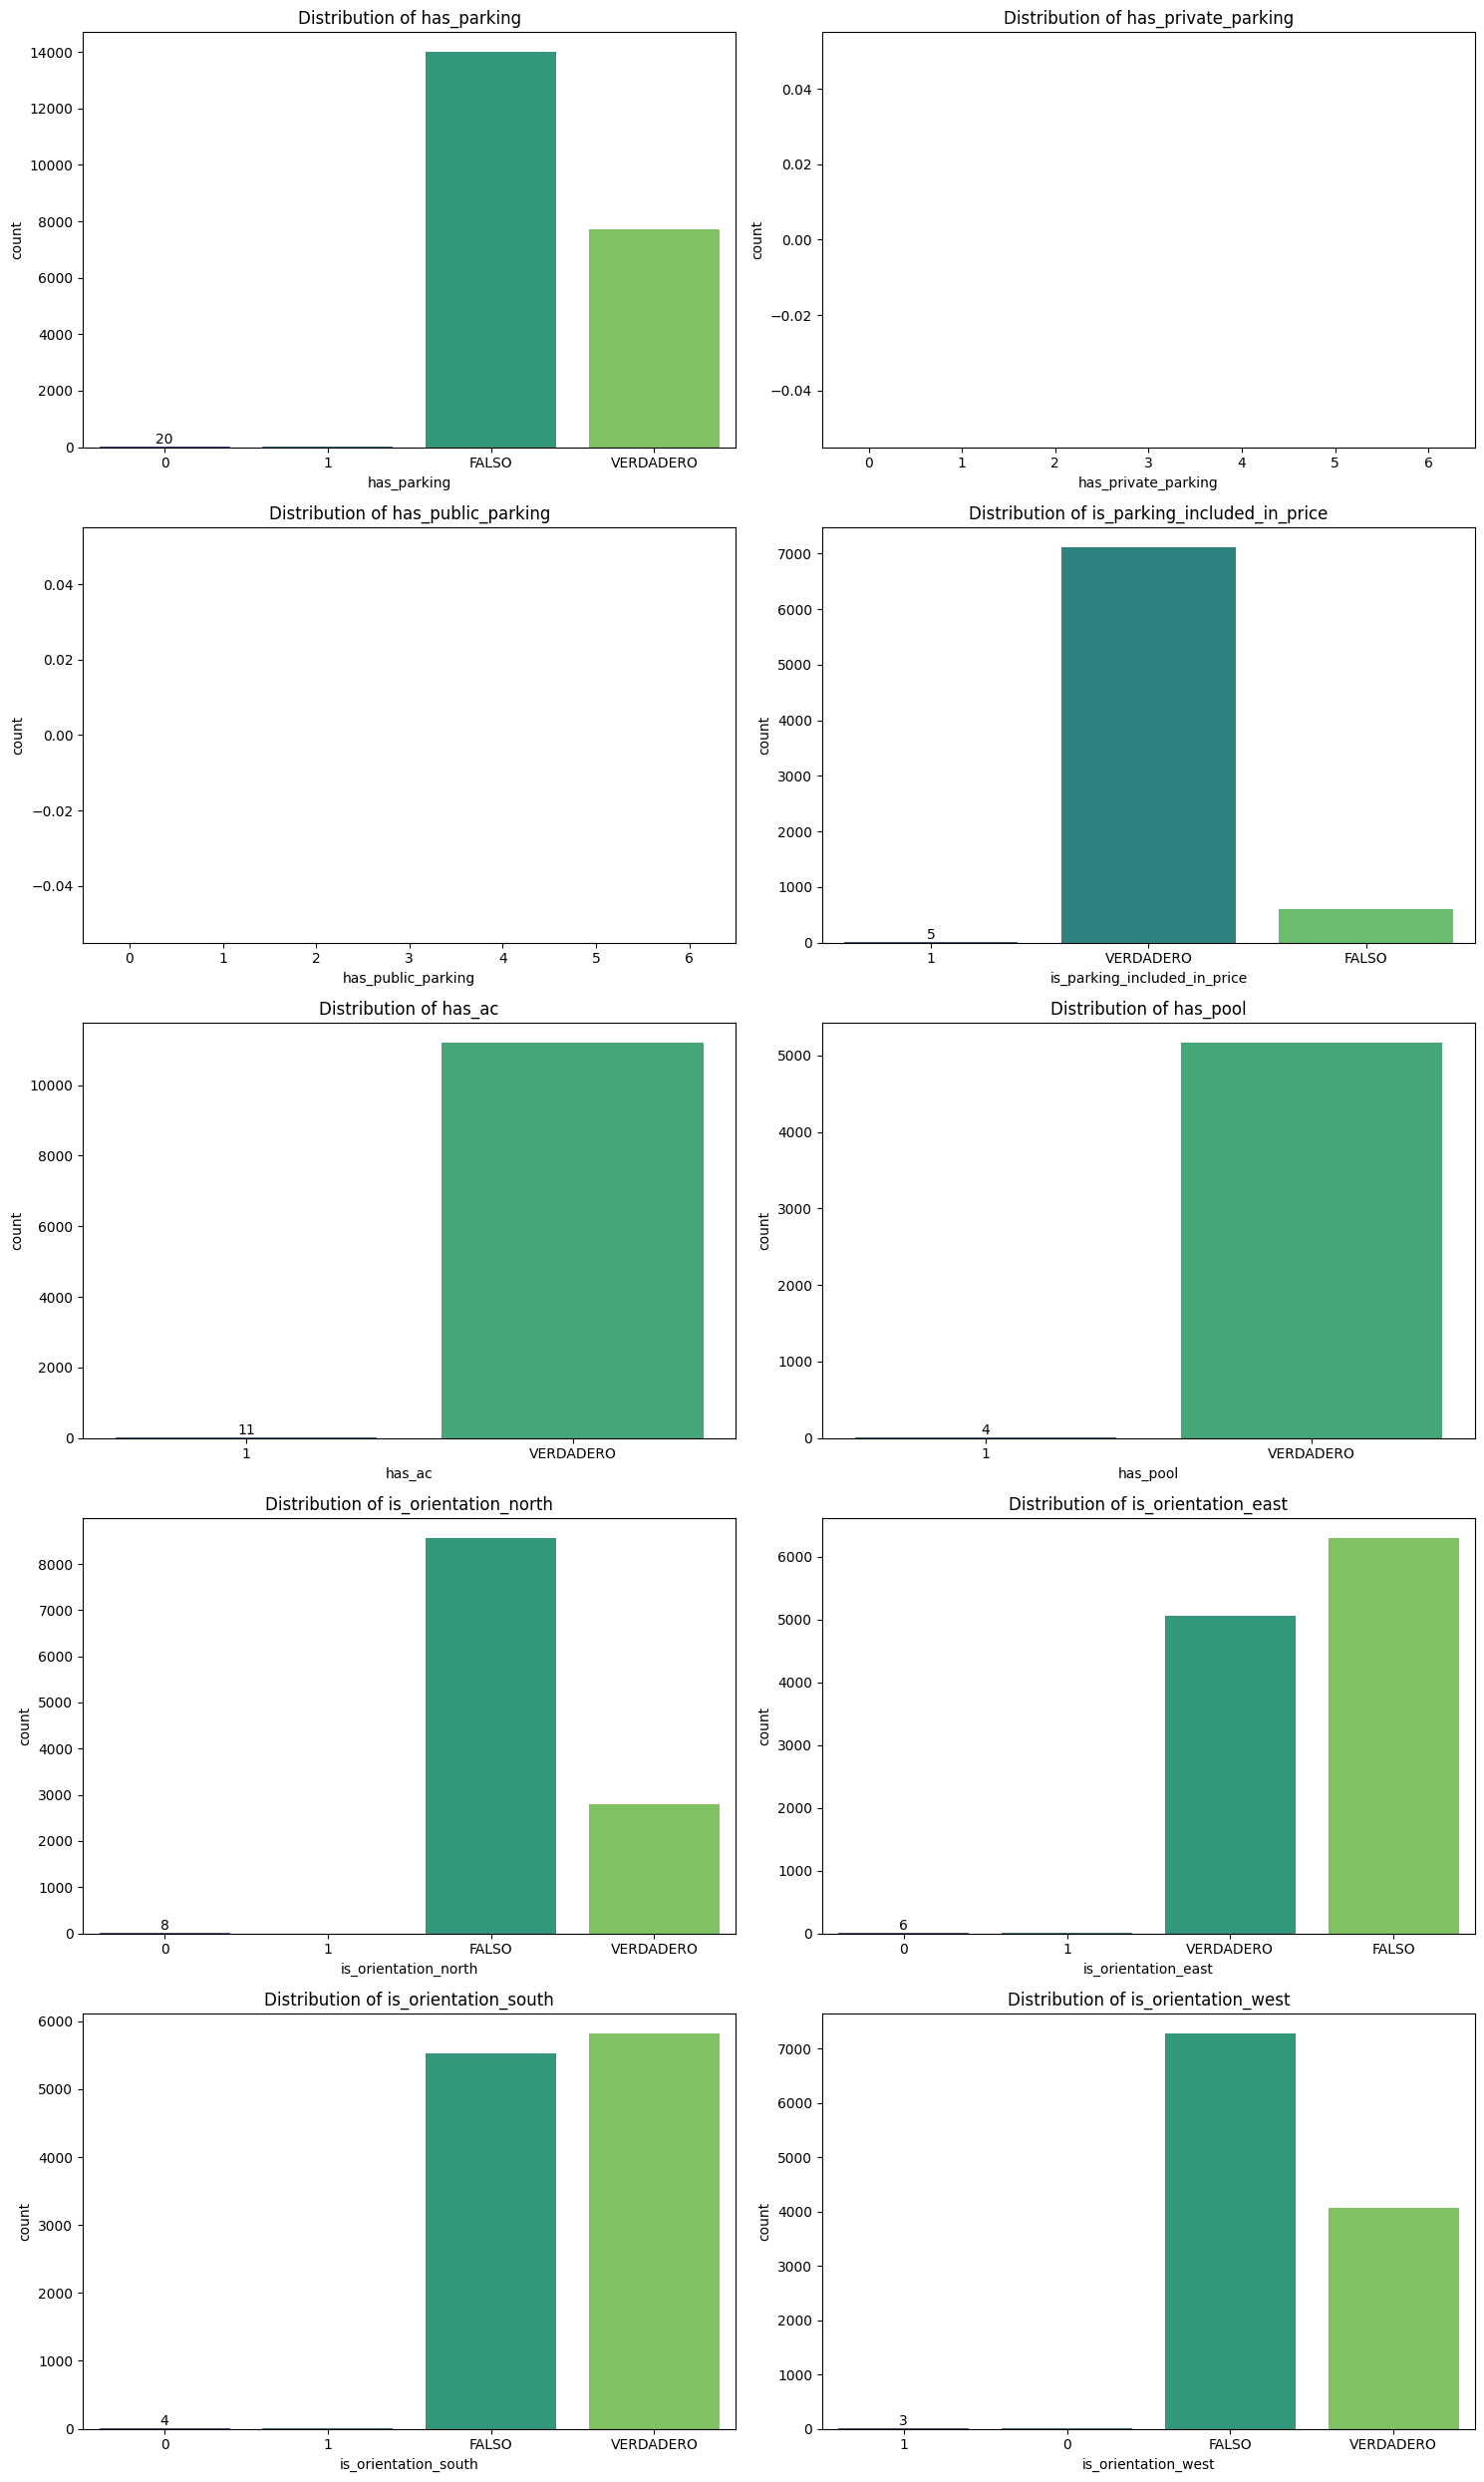

In [108]:
columns_to_analyze = ['has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price', 'has_ac', 'has_pool', 'is_orientation_north', 'is_orientation_east', 'is_orientation_south', 'is_orientation_west']

for column in columns_to_analyze:
    print(f"Distinct values in {column}:")
    print(df[column].value_counts(dropna=False))
    print('---------')

# Get the columns we're working with
columns_to_plot = columns_to_analyze
print(f"Columns being plotted: {columns_to_plot}")

# Create a grid of subplots with 2 columns
num_cols = len(columns_to_plot)
cols = 2
rows = num_cols // cols  # Calculate rows needed (ceiling division)
fig_height = rows * 5  # 5 pixels per row

fig, axes = plt.subplots(rows, cols, figsize=(15, fig_height))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through columns and create plots
for i, column in enumerate(columns_to_plot):
    if i < len(axes):  # Make sure we don't exceed the number of subplots
        sns.countplot(x=column, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        # Check if the container has elements before trying to label bars
        if axes[i].containers and len(axes[i].containers) > 0:
            axes[i].bar_label(axes[i].containers[0])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Column preprocessing

### Preprocess floor column

#### Standarization


Value counts
floor
 9.0     181
 8.0     326
 7.0     556
 6.0     913
 5.0    1310
 4.0    2323
 3.0    3001
 2.0    3546
 1.0    4440
 0.5     271
 0.0    2144
-0.5      92
-1.0      32
 NaN    2607
Name: count, dtype: int64
------------------------------------------------------------------------------
Mean: 2.6151816043898615
Median: 2.0
------------------------------------------------------------------------------


<Axes: title={'center': 'Floor distribution'}, ylabel='Frequency'>

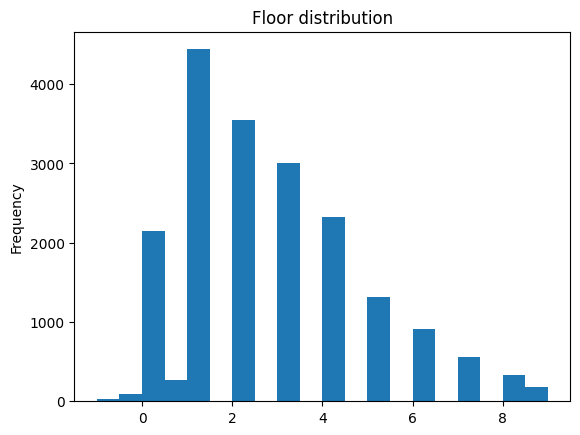

In [109]:
floor_map = {
    'Bajo': 0,
    'Entreplanta': 0.5,
    'Entreplanta interior': 0.5,
    'Entreplanta exterior': 0.5,
    'Semi-sótano': -0.5,
    'Semi-sótano interior': -0.5,
    'Semi-sótano exterior': -0.5,
    'Sótano': -1,
    'Sótano interior': -1,
    'Sótano exterior': -1
}

df['floor'] = df['floor'].replace(floor_map)
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

print("Value counts")
print(df['floor'].value_counts(dropna=False).sort_index(ascending=False))
print("------------------------------------------------------------------------------")
print("Mean:", df['floor'].mean())
print("Median:", df['floor'].median())
print("------------------------------------------------------------------------------")

df['floor'].plot(kind='hist', bins=20, title='Floor distribution')

#### Imputation of missing values

In [110]:
# 1. CORRELATION WITH NUMERIC FEATURES
original_df['floor'] = df['floor']
numeric_corr = original_df.corr(numeric_only=True)['floor'].drop('floor').sort_values(key=abs, ascending=False)

print("\n🔵 Numeric features most correlated with 'floor':")
print(numeric_corr)

# 2. VISUALIZE TOP CORRELATED NUMERIC FEATURES
top_numeric_features = numeric_corr[abs(numeric_corr) > 0.3].index  # threshold can be changed
if not top_numeric_features.empty:
    sns.pairplot(original_df, vars=top_numeric_features.tolist() + ['floor'])
    plt.show()

# 3. CORRELATION WITH CATEGORICAL FEATURES
categorical_cols = original_df.select_dtypes(include='object').columns  # object dtype = usually categorical

print("\n🟠 Average 'floor' by categorical feature:")
for col in categorical_cols:
    means = original_df.groupby(col)['floor'].mean().sort_values()
    print(f"\n{col}:\n{means}")

pvalues = []

for col in categorical_cols:
    groups = [group['floor'].dropna() for name, group in original_df.groupby(col)]
    if len(groups) > 1:
        f_val, p_val = scipy.stats.f_oneway(*groups)
        pvalues.append((col, p_val))

pvalues = sorted(pvalues, key=lambda x: x[1], reverse=True)


for pvalue in pvalues:
    print(f"ANOVA for {pvalue[0]}: p-value = {pvalue[1]}")


🔵 Numeric features most correlated with 'floor':
buy_price              0.157148
sq_mt_useful           0.151508
buy_price_by_area      0.148571
sq_mt_built            0.147173
n_rooms                0.146561
n_bathrooms            0.125489
built_year             0.034052
Unnamed: 0             0.025749
id                    -0.025749
parking_price          0.023478
rent_price            -0.023263
n_floors                    NaN
sq_mt_allotment             NaN
latitude                    NaN
longitude                   NaN
portal                      NaN
door                        NaN
rent_price_by_area          NaN
is_rent_price_known         NaN
are_pets_allowed            NaN
is_furnished                NaN
is_kitchen_equipped         NaN
has_private_parking         NaN
has_public_parking          NaN
Name: floor, dtype: float64

🟠 Average 'floor' by categorical feature:

title:
title
Piso en venta en General diaz porlier                     -1.0
Estudio en venta en calle de Bravo

No numeric column was found with sufficient correlation to conclude that they are related (values < 0.3). 

Because of that, we will just be using categorical columns with very small p-values. 
The column with the lowest p-value is is_floor_under, which has null values, and the second one is neighbourhood_id. We will group by neighbourhood_id and then impute with the median for that group.

In [111]:
valid_floors = df['floor'].dropna().unique()

def snap_to_valid_floor(x, valid_floors):
    if pd.isna(x):
        return np.nan

    return valid_floors[np.abs(valid_floors - x).argmin()]

df['floor'] = df['floor'].fillna(
    original_df.groupby(['neighborhood_id'])['floor'].transform('median')
)

# We remove values invented by the median (for instance, 2.5)
df['floor'] = df['floor'].apply(lambda x: snap_to_valid_floor(x, valid_floors))

We check that all the null values were properly imputed into valid values. Also, we can see that the distribution has remained almost the same.

Value counts
floor
 9.0     181
 8.0     326
 7.0     556
 6.0     913
 5.0    1310
 4.0    2348
 3.0    3721
 2.0    4886
 1.0    4962
 0.5     271
 0.0    2144
-0.5      92
-1.0      32
Name: count, dtype: int64
------------------------------------------------------------------------------
Mitjana: 2.552824027228406
Mediana: 2.0
------------------------------------------------------------------------------


<Axes: title={'center': 'Floor distribution'}, ylabel='Frequency'>

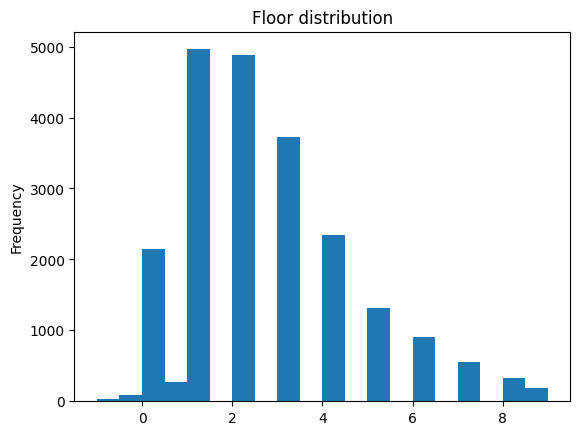

In [112]:
print("Value counts")
print(df['floor'].value_counts(dropna=False).sort_index(ascending=False))
print("------------------------------------------------------------------------------")
print("Mitjana:", df['floor'].mean())
print("Mediana:", df['floor'].median())
print("------------------------------------------------------------------------------")

df['floor'].plot(kind='hist', bins=20, title='Floor distribution')

### Preprocess n_rooms
#### Normalization

<Axes: title={'center': 'Distribución n_rooms después'}, ylabel='Frequency'>

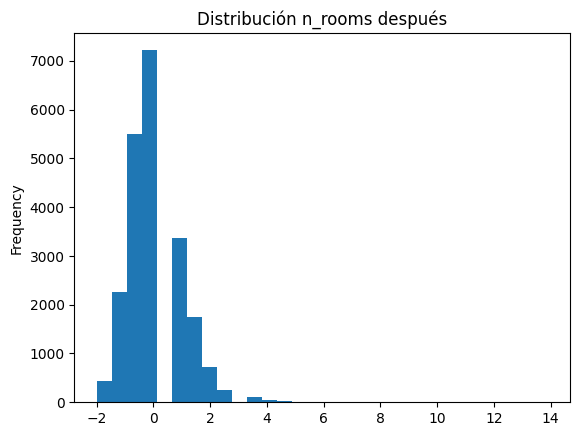

In [113]:
scaler = StandardScaler()
df['n_rooms'] = scaler.fit_transform(df[['n_rooms']])
df['n_rooms'].plot(kind='hist', bins=30, title='Distribución n_rooms después')

### Preprocess sq_mt_built column
#### Standarization, renaming, normalization and imputation

Mitjana: 146.9208919319023
Mediana: 100.0


<Axes: title={'center': 'Distribución sq_meters_built before'}, ylabel='Frequency'>

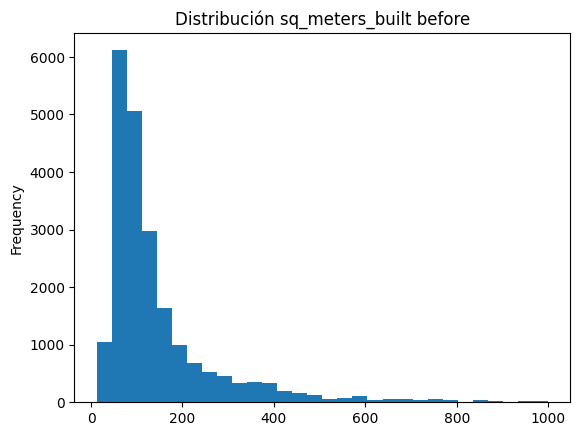

In [114]:
print("Mitjana:", df['sq_mt_built'].mean())
print("Mediana:", df['sq_mt_built'].median())
df['sq_mt_built'].plot(kind='hist', bins=30, title='Distribución sq_meters_built before')

We notice that there are some outliers, so it's best to use the median for the imputation

<Axes: title={'center': 'Distribución sq_meters_built after'}, ylabel='Frequency'>

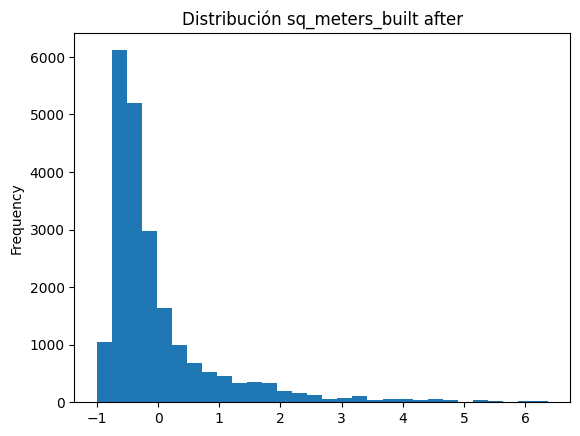

In [115]:
df['sq_mt_built'] = df['sq_mt_built'].fillna(df['sq_mt_built'].median())
scaler = StandardScaler()
df['sq_mt_built'] = scaler.fit_transform(df[['sq_mt_built']])
df['sq_mt_built'].plot(kind='hist', bins=30, title='Distribución sq_meters_built after')

### Preprocess sq_mt_useful column
#### Standarization, renaming, normalization and imputation

Mitjana: 103.45819154107924
Mediana: 79.0


<Axes: title={'center': 'Distribución sq_meters_useful before'}, ylabel='Frequency'>

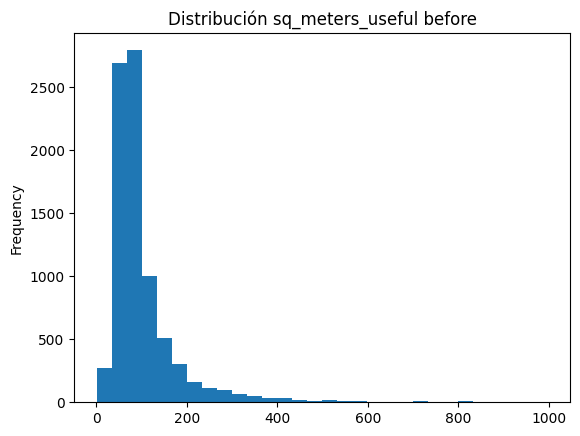

In [116]:
print("Mitjana:", df['sq_mt_useful'].mean())
print("Mediana:", df['sq_mt_useful'].median())
df['sq_mt_useful'].plot(kind='hist', bins=30, title='Distribución sq_meters_useful before')

We notice that there are some outliers, so it's best to use the median. We also see that the data needs to be normalized.

<Axes: title={'center': 'Distribución sq_meters_useful after'}, ylabel='Frequency'>

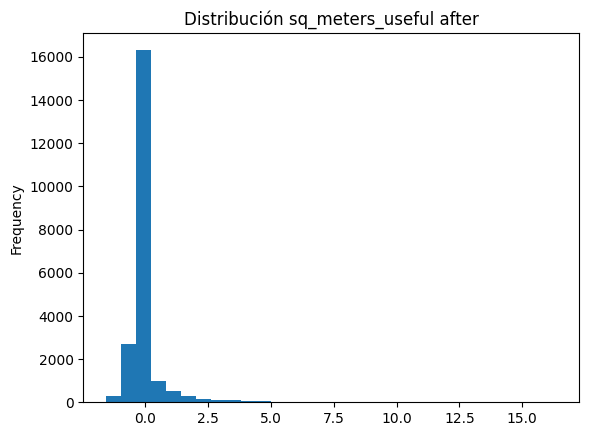

In [117]:
df['sq_mt_useful'] = df['sq_mt_useful'].fillna(df['sq_mt_useful'].median())
scaler = StandardScaler()
df['sq_mt_useful'] = scaler.fit_transform(df[['sq_mt_useful']])
df['sq_mt_useful'].plot(kind='hist', bins=30, title='Distribución sq_meters_useful after')

### Preprocess has_lift column
#### Standarization, renaming and imputation

has_lift
VERDADERO    14885
FALSO         4448
0               13
1               10
Name: count, dtype: int64


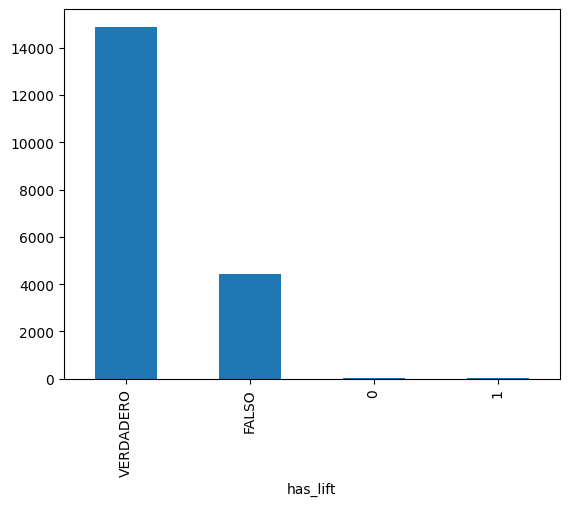

In [118]:
conteo = df['has_lift'].value_counts()
print(conteo)

df['has_lift'].value_counts().plot(kind='bar')
plt.show()

We impute null values ​​for has_lift. Since cases where it is unknown whether there is an elevator or not may be related to older, cheaper apartments, we create a new category, "unknown," represented by the number 2. We also see that some tuples have values ​​like "TRUE" or "FALSE," and others have "1" or "0." We leave all with 1 for true, 0 for false, and 2 for unknown values.

has_lift
1    14895
0     4461
2     2386
Name: count, dtype: int64


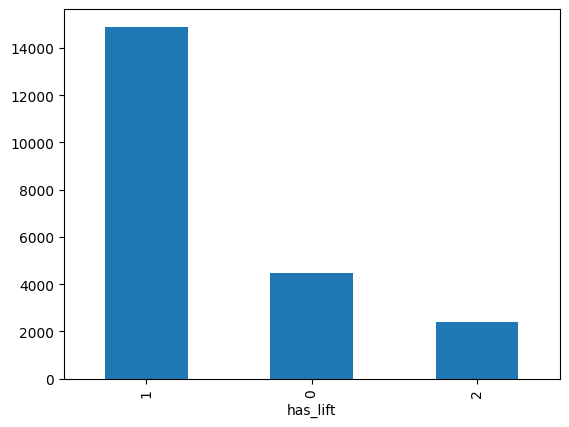

In [119]:
df['has_lift'] = df['has_lift'].fillna('unknown')
df['has_lift'] = df['has_lift'].astype(str)

df['has_lift'] = df['has_lift'].replace({
    'VERDADERO': '1',
    'FALSO': '0',
    'True': '1',
    'False': '0',
    'true': '1',
    'false': '0'
})
valores_validos = {'0', '1'}
df['has_lift'] = df['has_lift'].apply(lambda x: x if x in valores_validos else 'unknown')
df['has_lift'] = df['has_lift'].map({'0': 0, '1': 1, 'unknown': 2})
print(df['has_lift'].value_counts())

df['has_lift'].value_counts().plot(kind='bar')
plt.show()

### Preprocess house type column

#### Standarization and renaming

In [120]:
house_type_map = {
    'HouseType 1: Pisos' : 'Piso',
    'HouseType 2: Casa o chalet' : 'Casa',
    'HouseType 5: Áticos': 'Ático',
    'HouseType 4: Dúplex': 'Dúplex',
}

df['house_type'] = df['house_type_id'].replace(house_type_map)

print("Valores únicos en house_type:")
print(df['house_type'].value_counts(dropna=False))

Valores únicos en house_type:
house_type
Piso      17705
Casa       1938
Ático      1032
Dúplex      676
NaN         391
Name: count, dtype: int64


#### Imputation of missing values

Hay muy pocos valores nulos, de modo que podemos permitirnos imputarlos por la mediana.

In [121]:
df['house_type'].fillna(df['house_type'].mode()[0], inplace=True)

print("Valores únicos en house_type:")
print(df['house_type'].value_counts(dropna=False))

# fig, axes = plt.subplots(1, 1)
# sns.countplot(x='house_type', data=df, ax=axes, palette='viridis')
# axes.set_title('Distribución de house_type')
# axes.set_xlabel('house_type')
# axes.bar_label(axes.containers[0])

# plt.tight_layout()
# plt.show()

Valores únicos en house_type:
house_type
Piso      18096
Casa       1938
Ático      1032
Dúplex      676
Name: count, dtype: int64


### Preprocess heating_type column

#### Standarization and renaming

In [122]:
def determine_heating_type(row):
    if str(row['has_central_heating']).upper() in ['VERDADERO', '1']:
        return 'central'
    elif str(row['has_individual_heating']).upper() in ['VERDADERO', '1']:
        return 'individual'
    else:
        return 'unknown'

# Apply the function
df['heating_type'] = df.apply(determine_heating_type, axis=1)

print("Valores únicos en heating_type:")
print(df['heating_type'].value_counts(dropna=False))

Valores únicos en heating_type:
heating_type
individual    9516
unknown       8134
central       4092
Name: count, dtype: int64


### Preprocess street name column

#### Imputation of null values

In [123]:
df['street_name'] = df['street_name'].fillna('unknown')

print("Valores únicos en street_name:")
print(df['street_name'].value_counts(dropna=False))


Valores únicos en street_name:
street_name
unknown                                 5905
Paseo de la Castellana                   116
Calle de Bravo Murillo                    69
Calle del Príncipe de Vergara             60
Calle de Embajadores                      58
                                        ... 
Calle Peonias                              1
Calle de Hermenegildo Bielsa               1
Avenida de los arces                       1
Calle del Estrecho de Mesina, Madrid       1
Calle Burriana                             1
Name: count, Length: 6163, dtype: int64


We can see that there are 6163 columns, a lot of them with one one row of representation. Also, almost one third of the rows have an unknown street_name.

Consequently, we have decided to not use this column for the further training and classification.

### Preprocess floor column

#### Standarization

### Final processing

### Preprocess has pool column

#### Standarization and renaming

In [124]:
has_pool_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

df['has_pool'] = df['has_pool'].replace(has_pool_map)

print("Valores únicos en has_pool:")
print(df['has_pool'].value_counts(dropna=False))

Valores únicos en has_pool:
has_pool
NaN    16571
1.0     5171
Name: count, dtype: int64


#### Imputation of missing values

The missing values are false values.

In [125]:
df['has_pool'].fillna(0, inplace=True)

print("Valores únicos en has_pool:")
print(df['has_pool'].value_counts(dropna=False))

Valores únicos en has_pool:
has_pool
0.0    16571
1.0     5171
Name: count, dtype: int64


### Preprocess has air conditioner column

#### Standarization and renaming

In [126]:
has_ac_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

df['has_ac'] = df['has_ac'].replace(has_ac_map)

print("Valores únicos en has_ac:")
print(df['has_ac'].value_counts(dropna=False))

Valores únicos en has_ac:
has_ac
1.0    11211
NaN    10531
Name: count, dtype: int64


#### Imputation of missing values
There are no missing values

In [127]:
df['has_ac'].fillna(0, inplace=True)

print("Valores únicos en has_ac:")
print(df['has_ac'].value_counts(dropna=False))

Valores únicos en has_ac:
has_ac
1.0    11211
0.0    10531
Name: count, dtype: int64


### Preprocess has parking column

#### Explanation of different source of variables

There are 4 columns from the original dataset that describe things about the parking.

has_private_parking and has_public_parking do not provide any relevant information as all of their values are missing.

is_parking_included_in_price does not provide any extra information neither because all the available parkings are included in the price, so only has_parking provides valuable information.

In [128]:
# Count parkings that are not included in price
parkings_not_included = df[(df['has_parking'].isin(['1', 'VERDADERO'])) & 
                           (df['is_parking_included_in_price'].isna())].shape[0]

# Additional counts for context
parkings_included = df[(df['has_parking'].isin(['1', 'VERDADERO'])) & 
                       (df['is_parking_included_in_price'].notna())].shape[0]
total_parkings = df[df['has_parking'].isin(['1', 'VERDADERO'])].shape[0]

print("\nParking inclusion analysis:")
print(f"Parkings not included in price: {parkings_not_included}")
print(f"Parkings included in price: {parkings_included}")
print(f"Total properties with parking: {total_parkings}")


Parking inclusion analysis:
Parkings not included in price: 0
Parkings included in price: 7719
Total properties with parking: 7719


#### Standarization and renaming

In [129]:
has_parking_map = {
    '1' : 1,
    'VERDADERO' : 1,
    'FALSO' : 0,
    '0' : 0,
}

df['has_parking'] = df['has_parking'].replace(has_parking_map)

print("Valores únicos en has_parking:")
print(df['has_parking'].value_counts(dropna=False))

Valores únicos en has_parking:
has_parking
0    14023
1     7719
Name: count, dtype: int64


#### Imputation of missing values

There are no missing values.

### Preprocess orientation column

#### Standarization and renaming

In [130]:
orientation_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

for col in ORIENTATION_COLUMNS:
    df[col] = df[col].replace(orientation_map)

def combine_orientations(row):
    north = row['is_orientation_north']
    east = row['is_orientation_east']
    south = row['is_orientation_south']
    west = row['is_orientation_west']
    
    if north == 1 and east == 1 and south == 1 and west == 1:
        return 'all'
    
    orientations = []
    if north == 1:
        orientations.append('north')
    if east == 1:
        orientations.append('east')
    if south == 1:
        orientations.append('south')
    if west == 1:
        orientations.append('west')
    
    if not orientations:
        return 'unknown'
    
    return '-'.join(orientations)

df['orientation'] = df.apply(combine_orientations, axis=1)
print("Valores únicos en orientation:")
print(df['orientation'].value_counts(dropna=False))

Valores únicos en orientation:
orientation
unknown             10384
south                2522
east                 1797
west                 1383
east-south           1164
east-west             763
north                 744
south-west            711
north-south           530
all                   500
north-east            437
north-west            336
east-south-west       227
north-east-south       93
north-south-west       76
north-east-west        75
Name: count, dtype: int64


#### Imputation of missing values

As it is a categorical column, missing values have been converted to a new unknown class.

### Preprocess buy_price column (answer variable)

#### Analysis of the variable

Distinct values in buy_price:
buy_price
550000     170
135000     149
650000     146
130000     139
160000     138
          ... 
1879700      1
2279700      1
852000       1
2172000      1
388000       1
Name: count, Length: 2403, dtype: int64


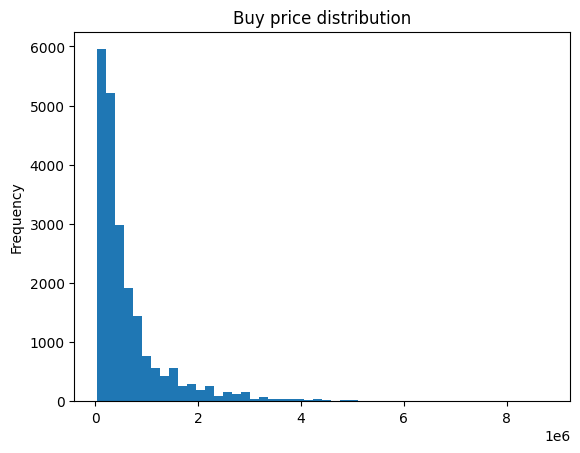

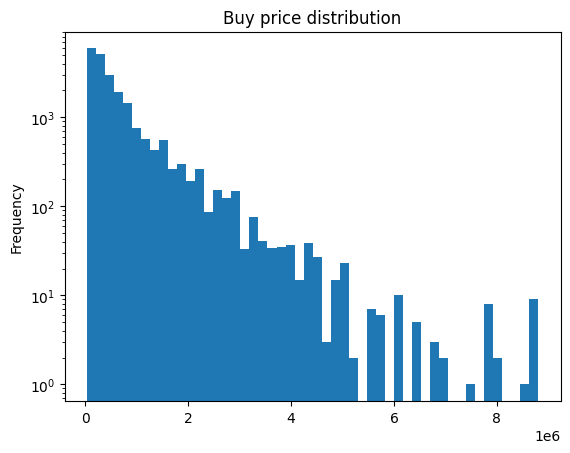

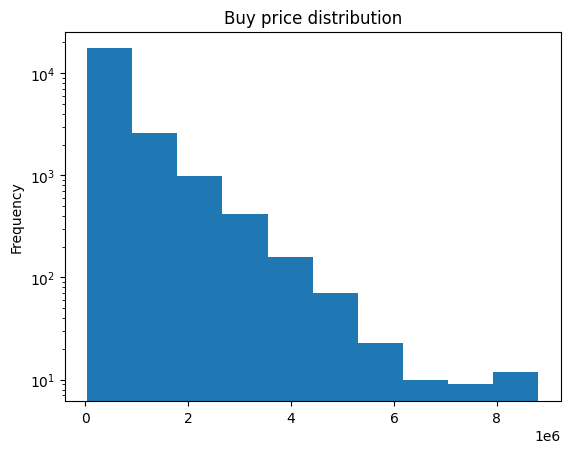

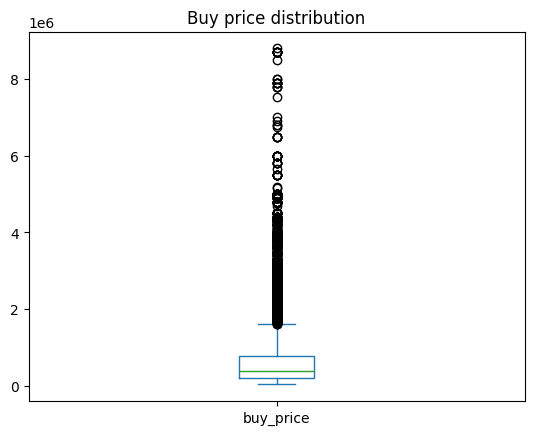

In [131]:
print("Distinct values in buy_price:")
print(df['buy_price'].value_counts(dropna=False))

df['buy_price'].plot(kind='hist', bins=50, title='Buy price distribution')
plt.show()
# Plot with logarithmic scale
df['buy_price'].plot(kind='hist', bins=50, title='Buy price distribution', logy=True)
plt.show()
# Plot with logarithmic scale and 10 bins
df['buy_price'].plot(kind='hist', bins=10, title='Buy price distribution', logy=True)
plt.show()
# Plot with boxplot
df['buy_price'].plot(kind='box', title='Buy price distribution')
plt.show()

#### Discretize the values

In [132]:
labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High']

# Preprocess
df['price_category'], bins = pd.qcut(df['buy_price'], 
                                     q=5, 
                                     labels=labels, 
                                     retbins=True)

Low: [36000.0, 175000.0)
Medium-Low: [175000.0, 288000.0)
Medium: [288000.0, 495000.0)
Medium-High: [495000.0, 899000.0)
High: [899000.0, 8800000.0)


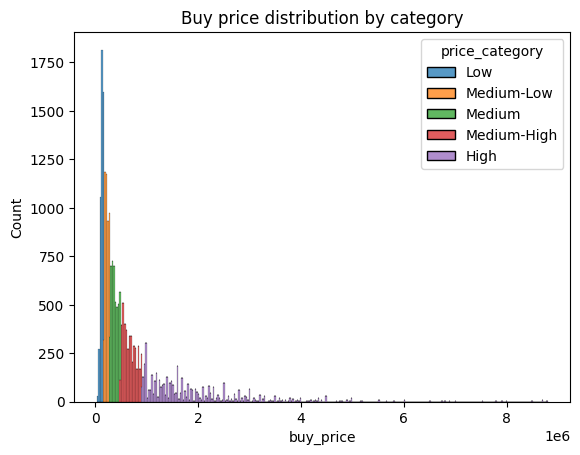

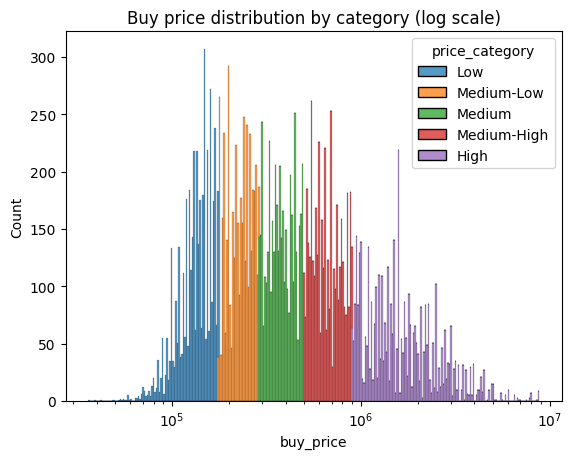

In [133]:
for i, label in enumerate(labels):
    print(f"{labels[i]}: [{bins[i]}, {bins[i+1]})")

sns.histplot(data=df, 
             x='buy_price', 
             hue='price_category', 
             bins=300, 
             log_scale=False, 
             multiple='stack')
plt.title('Buy price distribution by category')
plt.show()

sns.histplot(data=df, 
             x='buy_price', 
             hue='price_category', 
             bins=300, 
             log_scale=True, 
             multiple='stack')
plt.title('Buy price distribution by category (log scale)')
plt.show()

### Delete old columns

In [134]:
for col in HEATING_COLUMNS:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

if 'house_type_id' in df.columns:
    df.drop('house_type_id', axis=1, inplace=True)

# Drop orientation columns since we've created a combined 'orientation' column
for col in ORIENTATION_COLUMNS:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Drop redundant parking columns if they exist
if 'has_private_parking' in df.columns:
    df.drop('has_private_parking', axis=1, inplace=True)
if 'has_public_parking' in df.columns:
    df.drop('has_public_parking', axis=1, inplace=True)
if 'is_parking_included_in_price' in df.columns:
    df.drop('is_parking_included_in_price', axis=1, inplace=True)

if 'street_name' in df.columns:
    df.drop('street_name', axis=1, inplace=True)

if 'buy_price' in df.columns:
    df.drop('buy_price', axis=1, inplace=True)

## Final results

#### Final analysis

In [135]:
df.head()
nulls = df.isnull().mean() * 100
print("Porcentage de nulos por columna:")
display(nulls.sort_values(ascending=False))

Porcentage de nulos por columna:


floor             0.0
sq_mt_built       0.0
sq_mt_useful      0.0
n_rooms           0.0
has_lift          0.0
has_ac            0.0
has_pool          0.0
has_parking       0.0
house_type        0.0
heating_type      0.0
orientation       0.0
price_category    0.0
dtype: float64

#### Save preprocessed data

In [ ]:
# Save preprocessed data
df.to_csv('preprocessed.csv', index=False)